In [1]:
%matplotlib inline

In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

Load Data
---------



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!cp -r /content/drive/MyDrive/resnet50image /content

In [50]:
!cp -r /content/model_16.pt /content/drive/MyDrive/

In [4]:
!unzip /content/drive/MyDrive/resnet50image.zip -d /content

Archive:  /content/drive/MyDrive/resnet50image.zip
   creating: /content/resnet50image/
   creating: /content/resnet50image/train/
   creating: /content/resnet50image/train/0/
  inflating: /content/resnet50image/train/0/0_0_1_2_11_99.jpg  
  inflating: /content/resnet50image/train/0/2_0_480_47_2_71.jpg  
  inflating: /content/resnet50image/train/0/3_0_35_67_7_23.jpg  
  inflating: /content/resnet50image/train/0/4_0_128_5_5_49.jpg  
  inflating: /content/resnet50image/train/0/5_0_210_106_8_80.jpg  
  inflating: /content/resnet50image/train/0/5_0_916_106_8_80.jpg  
  inflating: /content/resnet50image/train/0/6_0_242_79_4_88.jpg  
  inflating: /content/resnet50image/train/0/9_0_485_28_10_75.jpg  
  inflating: /content/resnet50image/train/0/9_0_9_28_10_75.jpg  
  inflating: /content/resnet50image/train/0/11_0_42_76_7_100.jpg  
  inflating: /content/resnet50image/train/0/13_0_804_39_10_12.jpg  
  inflating: /content/resnet50image/train/0/15_0_72_3_9_22.jpg  
  inflating: /content/resnet50im

In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
        'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/resnet50image'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val','test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [6]:
dataloaders['test']

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



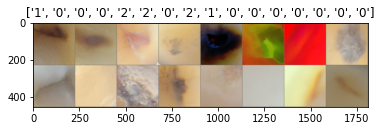

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Resnet101

In [24]:
model_101 = models.resnet101(pretrained=True)
# for param in model_101.parameters():
#     param.requires_grad = False
num_ftrs = model_101.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_101.fc = nn.Linear(num_ftrs, 3)#for resnet model

#model_ft.classifier[-1] = nn.Linear(in_features=4096, out_features=3)#for vgg model 
model_101 = model_101.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_101 = optim.SGD(model_101.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_101 = lr_scheduler.StepLR(optimizer_101, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [25]:
model_101 = train_model(model_101, criterion, optimizer_101, exp_lr_scheduler_101,
                       num_epochs=50)

Epoch 0/49
----------
train Loss: 0.7091 Acc: 0.6821
val Loss: 0.6598 Acc: 0.7105

Epoch 1/49
----------
train Loss: 0.4762 Acc: 0.8055
val Loss: 0.6342 Acc: 0.6903

Epoch 2/49
----------
train Loss: 0.3747 Acc: 0.8484
val Loss: 0.4995 Acc: 0.7591

Epoch 3/49
----------
train Loss: 0.3574 Acc: 0.8613
val Loss: 0.6359 Acc: 0.7652

Epoch 4/49
----------
train Loss: 0.2954 Acc: 0.8854
val Loss: 0.5799 Acc: 0.7713

Epoch 5/49
----------
train Loss: 0.2707 Acc: 0.9066
val Loss: 0.5087 Acc: 0.8219

Epoch 6/49
----------
train Loss: 0.2061 Acc: 0.9142
val Loss: 0.5258 Acc: 0.8138

Epoch 7/49
----------
train Loss: 0.1931 Acc: 0.9248
val Loss: 0.5607 Acc: 0.8097

Epoch 8/49
----------
train Loss: 0.1890 Acc: 0.9324
val Loss: 0.4739 Acc: 0.8239

Epoch 9/49
----------
train Loss: 0.1820 Acc: 0.9371
val Loss: 0.4942 Acc: 0.8198

Epoch 10/49
----------
train Loss: 0.1665 Acc: 0.9418
val Loss: 0.4976 Acc: 0.8259

Epoch 11/49
----------
train Loss: 0.1612 Acc: 0.9383
val Loss: 0.5001 Acc: 0.8198

Ep

In [26]:
evaluation(model_101)
score(model_101)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy on test images:  84.78260869565217 %
[[11  3  0]
 [ 2 22  0]
 [ 2  0  6]]
              precision    recall  f1-score   support

           0       0.73      0.79      0.76        14
           1       0.88      0.92      0.90        24
           2       1.00      0.75      0.86         8

    accuracy                           0.85        46
   macro avg       0.87      0.82      0.84        46
weighted avg       0.86      0.85      0.85        46



# Resnet-50

In [10]:
model_conv1 = torchvision.models.resnet50(pretrained=True)

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv1.fc.in_features
model_conv1.fc = nn.Linear(num_ftrs, 3)

model_conv1 = model_conv1.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv1 = optim.SGD(model_conv1.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler1 = lr_scheduler.StepLR(optimizer_conv1, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [11]:
model_conv1 = train_model(model_conv1, criterion, optimizer_conv1,
                         exp_lr_scheduler1, num_epochs=50)

Epoch 0/49
----------
train Loss: 0.8496 Acc: 0.5987
val Loss: 0.8501 Acc: 0.5769

Epoch 1/49
----------
train Loss: 0.6723 Acc: 0.7033
val Loss: 0.6703 Acc: 0.7065

Epoch 2/49
----------
train Loss: 0.6583 Acc: 0.7098
val Loss: 0.6659 Acc: 0.6903

Epoch 3/49
----------
train Loss: 0.5926 Acc: 0.7615
val Loss: 0.6662 Acc: 0.6680

Epoch 4/49
----------
train Loss: 0.5718 Acc: 0.7644
val Loss: 0.6523 Acc: 0.6883

Epoch 5/49
----------
train Loss: 0.5733 Acc: 0.7626
val Loss: 0.7405 Acc: 0.6397

Epoch 6/49
----------
train Loss: 0.5545 Acc: 0.7673
val Loss: 0.6415 Acc: 0.7227

Epoch 7/49
----------
train Loss: 0.5151 Acc: 0.7803
val Loss: 0.6356 Acc: 0.7126

Epoch 8/49
----------
train Loss: 0.5211 Acc: 0.7814
val Loss: 0.6093 Acc: 0.7308

Epoch 9/49
----------
train Loss: 0.5463 Acc: 0.7779
val Loss: 0.6094 Acc: 0.7611

Epoch 10/49
----------
train Loss: 0.5364 Acc: 0.7885
val Loss: 0.6228 Acc: 0.7470

Epoch 11/49
----------
train Loss: 0.5237 Acc: 0.7761
val Loss: 0.5985 Acc: 0.7490

Ep

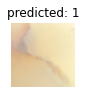

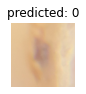

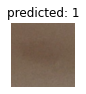

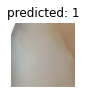

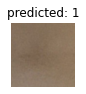

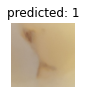

In [12]:
visualize_model(model_conv1)

plt.ioff()
plt.show()

In [16]:
evaluation(model_conv1)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy on test images:  78.26086956521739 %


In [17]:
score(model_conv1)

[[ 9  3  2]
 [ 2 22  0]
 [ 3  0  5]]
              precision    recall  f1-score   support

           0       0.64      0.64      0.64        14
           1       0.88      0.92      0.90        24
           2       0.71      0.62      0.67         8

    accuracy                           0.78        46
   macro avg       0.75      0.73      0.74        46
weighted avg       0.78      0.78      0.78        46



Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




# Vgg16

In [18]:
model_16 = models.vgg16(pretrained=True)
#num_ftrs = model_101.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
#model_101.fc = nn.Linear(num_ftrs, 3)#for resnet model

model_16.classifier[-1] = nn.Linear(in_features=4096, out_features=3)#for vgg model 
model_16 = model_16.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_16 = optim.SGD(model_16.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_16 = lr_scheduler.StepLR(optimizer_16, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [19]:
model_16 = train_model(model_16, criterion, optimizer_16, exp_lr_scheduler_16,
                       num_epochs=50)

Epoch 0/49
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6962 Acc: 0.7021
val Loss: 0.6377 Acc: 0.7024

Epoch 1/49
----------
train Loss: 0.4790 Acc: 0.7932
val Loss: 0.8005 Acc: 0.6336

Epoch 2/49
----------
train Loss: 0.4698 Acc: 0.8043
val Loss: 0.6514 Acc: 0.6700

Epoch 3/49
----------
train Loss: 0.4469 Acc: 0.8090
val Loss: 0.6532 Acc: 0.7247

Epoch 4/49
----------
train Loss: 0.3706 Acc: 0.8420
val Loss: 0.5468 Acc: 0.7935

Epoch 5/49
----------
train Loss: 0.3574 Acc: 0.8514
val Loss: 0.6255 Acc: 0.7692

Epoch 6/49
----------
train Loss: 0.3239 Acc: 0.8596
val Loss: 0.4966 Acc: 0.8158

Epoch 7/49
----------
train Loss: 0.2599 Acc: 0.9025
val Loss: 0.5563 Acc: 0.7976

Epoch 8/49
----------
train Loss: 0.2266 Acc: 0.9095
val Loss: 0.5758 Acc: 0.7773

Epoch 9/49
----------
train Loss: 0.2424 Acc: 0.9048
val Loss: 0.5871 Acc: 0.7773

Epoch 10/49
----------
train Loss: 0.2056 Acc: 0.9201
val Loss: 0.6015 Acc: 0.7874

Epoch 11/49
----------
train Loss: 0.2166 Acc: 0.9089
val Loss: 0.5723 Acc: 0.7854

Epoch 12/49
----------
t

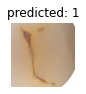

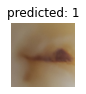

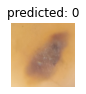

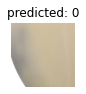

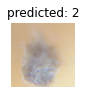

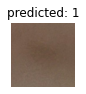

In [20]:
visualize_model(model_16)
plt.ioff()
plt.show()

In [21]:
evaluation(model_16)
score(model_16)

Accuracy on test images:  86.95652173913044 %
[[13  1  0]
 [ 4 20  0]
 [ 0  1  7]]
              precision    recall  f1-score   support

           0       0.76      0.93      0.84        14
           1       0.91      0.83      0.87        24
           2       1.00      0.88      0.93         8

    accuracy                           0.87        46
   macro avg       0.89      0.88      0.88        46
weighted avg       0.88      0.87      0.87        46



# AlexNet

In [37]:
model_ax = models.alexnet(pretrained=True)
# for param in model_101.parameters():
#     param.requires_grad = False
num_ftrs = model_ax.classifier[6].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ax.classifier[6] = nn.Linear(num_ftrs,3)#for resnet model

#model_ft.classifier[-1] = nn.Linear(in_features=4096, out_features=3)#for vgg model 
model_ax = model_ax.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ax = optim.SGD(model_ax.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_ax = lr_scheduler.StepLR(optimizer_ax, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [38]:
model_ax = train_model(model_ax, criterion, optimizer_ax, exp_lr_scheduler_ax,
                       num_epochs=50)

Epoch 0/49
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.7311 Acc: 0.6863
val Loss: 0.9044 Acc: 0.5405

Epoch 1/49
----------
train Loss: 0.5465 Acc: 0.7720
val Loss: 0.6503 Acc: 0.7287

Epoch 2/49
----------
train Loss: 0.4609 Acc: 0.8079
val Loss: 0.8900 Acc: 0.6397

Epoch 3/49
----------
train Loss: 0.4681 Acc: 0.8008
val Loss: 0.7870 Acc: 0.6640

Epoch 4/49
----------
train Loss: 0.4036 Acc: 0.8390
val Loss: 0.8518 Acc: 0.6923

Epoch 5/49
----------
train Loss: 0.3917 Acc: 0.8384
val Loss: 0.6968 Acc: 0.7449

Epoch 6/49
----------
train Loss: 0.3849 Acc: 0.8349
val Loss: 0.8595 Acc: 0.6518

Epoch 7/49
----------
train Loss: 0.3010 Acc: 0.8731
val Loss: 0.8752 Acc: 0.7247

Epoch 8/49
----------
train Loss: 0.2701 Acc: 0.8937
val Loss: 0.8212 Acc: 0.7328

Epoch 9/49
----------
train Loss: 0.2622 Acc: 0.8954
val Loss: 0.8492 Acc: 0.7247

Epoch 10/49
----------
train Loss: 0.2457 Acc: 0.9019
val Loss: 0.8392 Acc: 0.7389

Epoch 11/49
----------
train Loss: 0.2450 Acc: 0.9042
val Loss: 0.8147 Acc: 0.7409

Epoch 12/49
----------
t

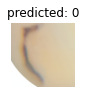

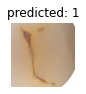

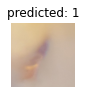

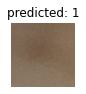

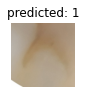

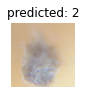

In [42]:
visualize_model(model_ax)

In [43]:
evaluation(model_ax)
score(model_ax)

Accuracy on test images:  82.6086956521739 %
[[13  1  0]
 [ 3 20  1]
 [ 3  0  5]]
              precision    recall  f1-score   support

           0       0.68      0.93      0.79        14
           1       0.95      0.83      0.89        24
           2       0.83      0.62      0.71         8

    accuracy                           0.83        46
   macro avg       0.82      0.80      0.80        46
weighted avg       0.85      0.83      0.83        46



# DenseNet121

In [33]:
model_d121 = models.densenet121(pretrained=True)

num_ftrs = model_d121.classifier.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_d121.classifier = nn.Linear(num_ftrs,3)#for resnet model

#model_ft.classifier[-1] = nn.Linear(in_features=4096, out_features=3)#for vgg model 
model_d121 = model_d121.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_d121 = optim.SGD(model_d121.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_121 = lr_scheduler.StepLR(optimizer_d121, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [34]:
model_d121 = train_model(model_d121, criterion, optimizer_d121, exp_lr_scheduler_121,
                       num_epochs=50)

Epoch 0/49
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.7268 Acc: 0.6739
val Loss: 0.7068 Acc: 0.6660

Epoch 1/49
----------
train Loss: 0.5148 Acc: 0.7844
val Loss: 0.5947 Acc: 0.7834

Epoch 2/49
----------
train Loss: 0.4268 Acc: 0.8214
val Loss: 0.7168 Acc: 0.6842

Epoch 3/49
----------
train Loss: 0.4289 Acc: 0.8184
val Loss: 0.6210 Acc: 0.7166

Epoch 4/49
----------
train Loss: 0.3673 Acc: 0.8555
val Loss: 0.6945 Acc: 0.7449

Epoch 5/49
----------
train Loss: 0.3319 Acc: 0.8678
val Loss: 0.7159 Acc: 0.7753

Epoch 6/49
----------
train Loss: 0.3083 Acc: 0.8778
val Loss: 0.5198 Acc: 0.7713

Epoch 7/49
----------
train Loss: 0.2574 Acc: 0.8942
val Loss: 0.5137 Acc: 0.7794

Epoch 8/49
----------
train Loss: 0.2400 Acc: 0.9125
val Loss: 0.5052 Acc: 0.8016

Epoch 9/49
----------
train Loss: 0.2134 Acc: 0.9101
val Loss: 0.5028 Acc: 0.7996

Epoch 10/49
----------
train Loss: 0.2226 Acc: 0.9172
val Loss: 0.6120 Acc: 0.7834

Epoch 11/49
----------
train Loss: 0.2214 Acc: 0.9201
val Loss: 0.5179 Acc: 0.8057

Epoch 12/49
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


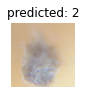

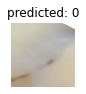

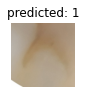

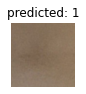

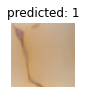

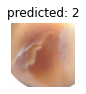

In [35]:
visualize_model(model_d121)

In [36]:
evaluation(model_d121)
score(model_d121)

Accuracy on test images:  84.78260869565217 %
[[12  2  0]
 [ 2 21  1]
 [ 2  0  6]]
              precision    recall  f1-score   support

           0       0.75      0.86      0.80        14
           1       0.91      0.88      0.89        24
           2       0.86      0.75      0.80         8

    accuracy                           0.85        46
   macro avg       0.84      0.83      0.83        46
weighted avg       0.85      0.85      0.85        46



#Result

In [14]:
def evaluation(model):

  correct = 0
  total = 0
  preds=[]
  target=[]
  with torch.no_grad():
      for data in dataloaders['test']:
          images, labels = data
          images, labels = images.to('cuda'), labels.to('cuda')
          outputs = model(images)
        
          target.append(labels)
          
          _, predicted = torch.max(outputs.data, 1)
          preds.append(predicted)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  print('Accuracy on test images: ', 100*(correct/total), '%')


In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def score(model):

  nb_classes = 3

  # Initialize the prediction and label lists(tensors)
  predlist=torch.zeros(0,dtype=torch.long, device='cpu')
  lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

  with torch.no_grad():
      for i, (inputs, classes) in enumerate(dataloaders['test']):
          inputs = inputs.to(device)
          classes = classes.to(device)
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)

          # Append batch prediction results
          predlist=torch.cat([predlist,preds.view(-1).cpu()])
          lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

  # Confusion matrix
  conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
  print(conf_mat)
  print(classification_report(lbllist.numpy(), predlist.numpy()))

In [48]:
torch.save(model_d121, '/content/model_d121.pt')